 # <span style="color:red"> Excercise </span>
 ## Building small Ontology using Hearst Pattern
In this problem, you will employ the POS, lemma and chunking information to discover <span style="color:blue">lexical relationships</span> in a corpus.

<span style="color:blue">Hearst patterns</span> are lexico-syntactic patterns first used by [Marti Hearst](http://people.ischool.berkeley.edu/~hearst/papers/coling92.pdf) to discover <span style="color:blue"><span style="color:blue">hyponyms</span></span> in large text corpora. (A **hyponym** is a term which denotes a more specific or subordinate group of another term, called a  <span style="color:blue">hypernym</span>. For example, <span style="color:blue">tiger</span> is a hyponym of  <span style="color:blue">mammal</span>, which is in turn a hyponym of <span style="color:blue">animal</span>. Therefore animal is a hypernym of mammal, and mammal is a hypernym of tiger.) 

Hearst observed that certain linguistic constructions can be used to infer hyponymy relationships. For example, in the phrase “works by such <span style="color:blue">authors</span> as <span style="color:blue">Herrick</span>, <span style="color:blue">Goldsmith</span>, and <span style="color:blue">Shakespeare</span>”, it is obvious that Herrick, Goldsmith, and Shakespeare are all hyponyms of author. In general, any phrase of the pattern “<span style="color:blue">such NP0 as NP1, . . . , and NPn</span>” implies that the noun phrases NP1 through NPn are hyponyms of NP0. The following table shows some patterns originally proposed by Hearst, along with examples. 
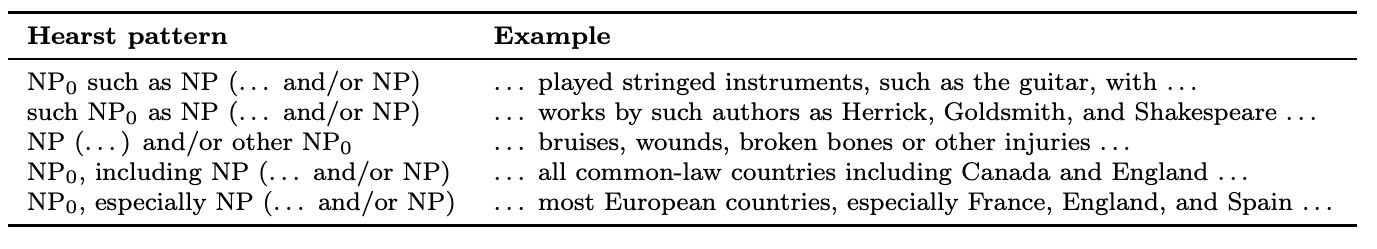

---
---

Write a Python program which looks for hyponyms by finding Hearst patterns in a collection of documents.

 1. Write a program that will read a file or list of files, iterate over each sentences and extract possible <span style="color:blue">hyponym/hypernym</span> relations.  <span style="color:red"> </span> 
 2. Once the relations are extracted, report the total number of relations/patterns as follows  <span style="color:red"></span> :
* Print out the most commonly found <span style="color:blue">hyponym-hypernym relations</span>
 
Example output: 

|  count | Hyponym   | Hypernym |
|---|:----------|:---|
| 45  | house | building |
| 32   | Herrick  | author|
| 11  | France  |  country

* Print the top five most <span style="color:blue">productive Hearst patterns</span>

Example output:

|  count | Hearst pattern   | 
|---|:----------|
| 1302  | NP such as NP | 
| 800   | such NP as NP  | 
| 452  | NP, including NP  |  
| 121 | NP, especially NP |
| 32 | NP and/or other NP |

 In this exercise, you can use either <span style="color:blue">NLTK</span>, <span style="color:blue">TextBlob</span>, or <span style="color:blue">spaCy</span> chunkers, or a combination of them to implement Hearst Pattern. We will run your script to test sentences to determine how much patterns your implementation covers.
 
 You can use the corpus `wiki-1000.txt` in the folder `HearstPaternData`. You can compare your output to some of the files there such as `pattern_out_0.txt`.

## Resources
* [Learning POS Tagging & Chunking in NLP](https://medium.com/greyatom/learning-pos-tagging-chunking-in-nlp-85f7f811a8cb)
* [TextBlob Chunking](https://textblob.readthedocs.io/en/dev/advanced_usage.html#noun-phrase-chunkers)
* [Chunking in NLTK](https://www.nltk.org/book/ch07.html)
* [Hearst Pattern](https://aclanthology.org/P18-2057.pdf)
* [Dependency Parsing](https://web.stanford.edu/~jurafsky/slp3/14.pdf)
* [Stanza](https://stanfordnlp.github.io/stanza/pipeline.html)

In [6]:
!pip install spacy
!spacy download en_core_web_sm

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.8.0/en_core_web_sm-3.8.0-py3-none-any.whl (12.8 MB)
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [9]:
import os
import re
import spacy
from collections import Counter
from typing import List, Tuple

# Load the small English NLP model from spaCy
nlp = spacy.load("en_core_web_sm")

# Function to read file contents
def read_file(file_path: str) -> List[str]:
    """Read text from a file and return a list of sentences."""
    with open(file_path, "r") as file:
        text = file.read()
        text = re.sub(r'\n', ' ', text)  # Clean new lines
        doc = nlp(text)
        sentences = [sent.text for sent in doc.sents]
    return sentences

# Function to extract hyponym-hypernym relations
def extract_relations(sentences: List[str]) -> List[Tuple[str, str, str]]:
    """Extract hyponym-hypernym relations and identify the Hearst pattern."""
    patterns_relations = []

    # Define patterns based on common Hearst patterns
    hearst_patterns = [
        ("such {NP} as {NP}", "such {} as {}"),
        ("{NP} including {NP}", "{} including {}"),
        ("{NP}, especially {NP}", "{}, especially {}"),
        ("{NP} and other {NP}", "{} and other {}"),
        ("{NP} or other {NP}", "{} or other {}")
    ]

    for sentence in sentences:
        doc = nlp(sentence)

        # Check each pattern
        for pattern, output_format in hearst_patterns:
            if pattern.split()[0] in sentence:
                for token in doc:
                    # Capture hypernym-hyponym pairs using pattern-specific checks
                    if token.dep_ == "prep" and token.text in ["as", "including", "especially"]:
                        hyponym = token.head.text
                        hypernym = [child.text for child in token.head.children if child.dep_ == "pobj"]
                        if hypernym:
                            patterns_relations.append((hyponym, hypernym[0], output_format.format(hyponym, hypernym[0])))
                    elif token.text == "other" and token.head.dep_ == "conj":
                        hyponym = token.head.head.text
                        hypernym = token.head.text
                        patterns_relations.append((hyponym, hypernym, output_format.format(hyponym, hypernym)))

    return patterns_relations

# Aggregation function to count relations and patterns
def analyze_relations(patterns_relations: List[Tuple[str, str, str]]):
    """Analyze relations and print common relations and patterns."""
    relations_counter = Counter([(rel[0], rel[1]) for rel in patterns_relations])
    patterns_counter = Counter([rel[2] for rel in patterns_relations])

    # Most common hyponym-hypernym relations
    common_relations = relations_counter.most_common(5)

    # Most productive patterns
    common_patterns = patterns_counter.most_common(5)

    return common_relations, common_patterns

# File path setup
file_path = "data/wiki-1000.txt"
if os.path.exists(file_path):
    sentences = read_file(file_path)
    relations = extract_relations(sentences)
    common_relations, common_patterns = analyze_relations(relations)

    print(relations)

    # store in file data/out.txt
    with open("data/out.txt", "w") as file:
        for relation in relations:
            file.write(str(relation) + "\n")

else:
    print("The specified file path does not exist.")

[('neuropeptides', 'neurotransmitters', 'such neuropeptides as neurotransmitters')]
